In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras as k
import tensorflow as tf

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation,LSTM, GRU, Conv2D,MaxPooling2D, Flatten, Dropout,Convolution1D, Dense, MaxPooling1D
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.layers import BatchNormalization

from keras.models import Sequential
from keras.layers import Dense
import numpy as np


from keras.callbacks import History 
history = History()


2024-07-22 09:54:27.974405: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Cargamos el DATASET que se proporcionó en clase y que se obtuvo originalmente desde :
https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/version/3
y nos quedamos con la serie temporal de precios de apertura (columna "Open")


In [2]:
import pandas as pd
dd_googl = pd.read_csv("googl.us.txt", delimiter=",")
googl_op = dd_googl['Open']

La definición de las funciónes incluyendo la nueva opción "MIX" en el parametro "property"

In [3]:
def make_timeseries_regressor2(window_size, filter_length, nb_input_series=1, nb_outputs=1, nb_filter=4, property='LSTM'):
    """Devuelve un Modelo Keras para predecir el siguiente valor de una serie temporal dada una ventanta (window_size) de valores
    previos. Este modelo puede manejar multiples series de entrada (nb_input_series) y de preducciones (nb_outputs).
        *-* nb_input_series=1 si solo se le pasa una serie temporal
        *-* X : serie temporal de entrada, debe ser un array de dimension [n_instances, window_size, nb_input_series]
            Cada instancia de n_instances será un array 2D de dimensión [window_size, nb_input_series]. Si window=3, una instancia
            podría ser los 3 primeros elementos de la serie temporal "[0,1,2]". 
            Para dividir la serie temporal en "instancias", se dispone de la función make_timeseries_instances2
        *-* nb_outputs: Dimensión de la salida del modelo, generalmente será la misma dimensión que el numero de inputs. Para cada
            instancia de entrada, la salida será un vector de tamaño "nb_outputs", normalmente los valores predichos por el modelo
            como siguientes valores en la serie 
        *-* y : será un array de dimensión [n_instances, nb_outputs].
        *-* Filter_lenght: Es el tamaño del filtro que se aplicará a lo largo del "window_side" con ventana móvil para obtener
            la convolución de esos valores a lo largo de la instancia. 
            La diferencia entre convolucion 1D y 2D es que la "altura" del filtro 1D se corresponde con el numero de series
            temporales proporcionadas y su anchura es el "filter_lengh" pasado como parámetro. Se deslizará a lo largo de 
            la ventana definida. Esto es util para series temporales sin relación espacial/de ordenl
        *-* nb_filter : numero de diferentes filtros para aprender (aprox.los patrones de entrada a reconocer)
    """
    if property=='LSTM': 
                model = Sequential((
                    LSTM(64, input_shape=(window_size, nb_input_series),
                         dropout=0.2, recurrent_dropout=0.2, return_sequences = True),
                    #Le pido que devuelva toda la secuencia y con ello puedo volver a poner otra LSTM poruqe no pierdo 
                    #el caracter temporalya que cada secuencia que va a procesar, el siguiente nivel que coja esa secuencia y la procese.
                    LSTM(64, input_shape=(window_size, nb_input_series),dropout=0.2,recurrent_dropout=0.2),
                    Dense(nb_outputs, activation='linear')                 
                ))
    elif property=='GRU':
                model = Sequential((
                    GRU(64, input_shape=(window_size, nb_input_series)),
                    Dense(nb_outputs, activation='linear')
                ))
    elif property=='CNN':
                model = Sequential((
                Convolution1D(filters=nb_filter, kernel_size=filter_length, activation="relu", 
                      input_shape=(window_size, nb_input_series))
                        ,MaxPooling1D(), # Downsample the output of convolution by 2X.
                Convolution1D(filters=nb_filter, kernel_size=filter_length, activation="relu"),
                        MaxPooling1D(), Flatten(),Dense(nb_outputs, activation='linear'),  # For binary classification, change the activation to 'sigmoid'
                ))
    elif property=='MIX':
                model = Sequential((
                    LSTM(64, input_shape=(window_size, nb_input_series),
                         dropout=0.2, recurrent_dropout=0.2, return_sequences = True),
                    #Le pido que devuelva toda la secuencia y con ello puedo volver a poner otra LSTM poruqe no pierdo 
                    #el caracter temporalya que cada secuencia que va a procesar, el siguiente nivel que coja esa secuencia y la procese.
                    GRU(64, input_shape=(window_size, nb_input_series), return_sequences=True ),
                    Convolution1D(filters=nb_filter, kernel_size=filter_length, activation="relu", 
                      input_shape=(window_size, nb_input_series)),
                    MaxPooling1D(), # Downsample the output of convolution by 2X.
                    Convolution1D(filters=nb_filter, kernel_size=filter_length, activation="relu"),
                    MaxPooling1D(), Flatten(),
                    Dense(nb_outputs, activation='linear'),  # For binary classification, change the activation to 'linear'                             
                ))
    
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    # Si quisiereamos clasificación "binaria", compilaríamos como model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    return model

def make_timeseries_instances2(timeseries, window_size):
    """A partir de una serie temporal pasada como entrada, devuelve tupla de (X,y,q) donde X serán las entradas del predictor,
    un array 3D con dimensiones (( timeseries.shape[0]-window_size, window_size, timeseries.shape[1] o 1 ))
    Para cada fila de X, el correspondiente fila de "y" es el proximo valor de la serie temporal.
    El valor "q" o "query" es la última instancia que se utilizará para predecir un hipotetico (no proporcionado) valor
    de la serie temporal.
    *-* timeseries : Será un vector o matriz (time-step, series_num) donde el tiempo será el axis=0, las filas, y los valores
    serán el axis=1 (columnas)  
    *-* window_size esl el numero de muestras a utiizar como intrada en la predicción 
    """
    timeseries = np.asarray(timeseries)
    assert 0 < window_size < timeseries.shape[0]
    X = np.atleast_3d(np.array([timeseries[start:start + window_size] for start in range(0, timeseries.shape[0] - window_size)]))
    y = timeseries[window_size:]
    q = np.atleast_3d([timeseries[-window_size:]])
    return X, y, q

def evaluate_timeseries2(timeseries, window_size,ModelProp):
    """Crea un Predictor mediante una red CNN de dimension 2D para predecir el proximo valor de una serie temporal utilizando 
    los fragmentos anteriores de dicha serie con tamaño window_Size como características de entrada y evalua su rendimiento.
    *-* timeseries: Serie temporal con los valores de más lejano [elemento 0 ] a mas cercano [dimensión de "timeseries"]
    *-* window_size : numero de valores de la serie temporal a usar para predecir el siguiente.
    """
    filter_length = 5  #Kernel_size
    nb_filter = 4      #Filters
    n_epochs = 10
    
    timeseries = np.atleast_2d(timeseries)
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T       # Convert 1D vectors to 2D column vectors

    nb_samples, nb_series = timeseries.shape
    print('\n\nTimeseries ({} samples by {} series):\n'.format(nb_samples, nb_series), timeseries)
    model = make_timeseries_regressor2(window_size=window_size, filter_length=filter_length, 
                                       nb_input_series=nb_series, nb_outputs=nb_series, nb_filter=nb_filter,property=ModelProp)
    print('\n\nModel with input size {}, output size {}, {} conv filters of length {}'.format(model.input_shape, model.output_shape, nb_filter, filter_length))
    model.summary()

    X, y, q = make_timeseries_instances2(timeseries, window_size)
    print('\n\nInput features:', X, '\n\nOutput labels:', y, '\n\nQuery vector:', q, sep='\n')
    test_size = int(0.01 * nb_samples)           # In real life you'd want to use 0.2 - 0.5
    X_train, X_test, y_train, y_test = X[:-test_size], X[-test_size:], y[:-test_size], y[-test_size:]
    
    historyRet=model.fit(X_train, y_train, epochs=n_epochs, batch_size=int(window_size/5), validation_data=(X_test, y_test),callbacks=[history])

    pred = model.predict(X_test)
    print('\n\nactual', 'predicted', sep='\t')
    for actual, predicted in zip(y_test, pred.squeeze()):
        print(actual.squeeze(), predicted, sep='\t')
    print('next', model.predict(q).squeeze(), sep='\t')
   
    return historyRet

Procedemos a ejecutar elnuevo modelo y a **graficar el rendimiento del mismo**. 

In [4]:
# ASIGNAMOS LOS HIPERPARÁMETROS de nuestros modelos
"""Prepare input data, build model, evaluate."""
np.set_printoptions(threshold=25)
ts_length = 3000
window_size = 50


timeseries = googl_op.values # The timeseries f(t) = t

# Evaluamos el MODELO
model1_log=evaluate_timeseries2(timeseries, window_size, ModelProp='MIX')




Timeseries (3333 samples by 1 series):
 [[  50.   ]
 [  50.505]
 [  55.375]
 ...
 [1050.05 ]
 [1048.   ]
 [1043.87 ]]


Model with input size (None, 50, 1), output size (None, 1), 4 conv filters of length 5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 64)            16896     
                                                                 
 gru (GRU)                   (None, 50, 64)            24960     
                                                                 
 conv1d (Conv1D)             (None, 46, 4)             1284      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 23, 4)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 19, 4)   

### Graficamos los datos resultante del nuevo modelo que combina capas  CNN, LSTM y GRU.  Para ello pintamos el MAE y la función de coste LOSS tanto para el proceso de entrenamiento como para el proceso de Validación .


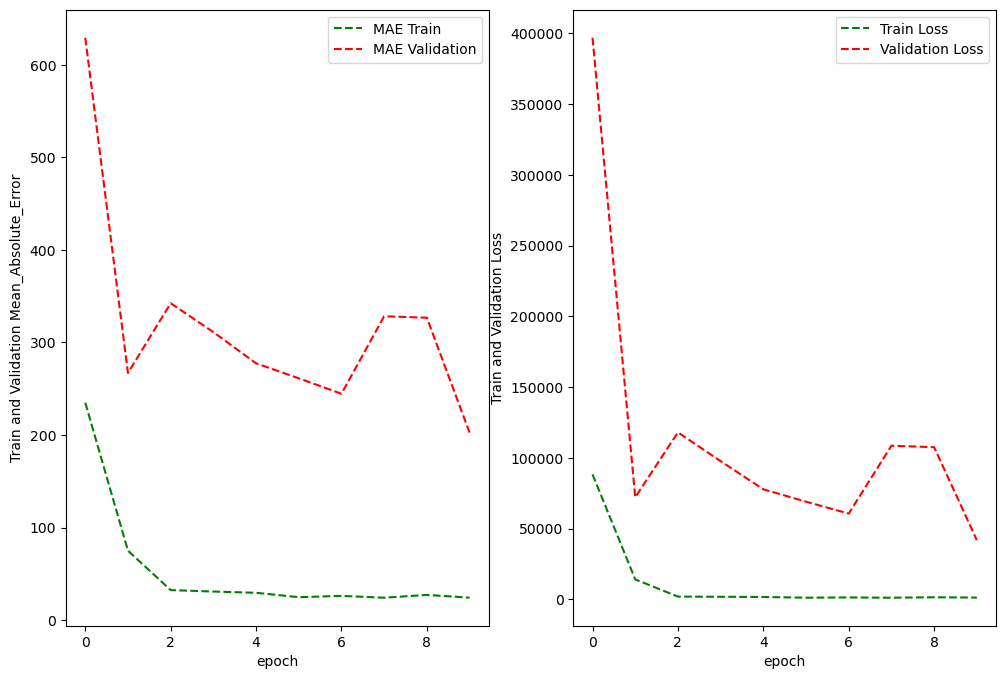

In [5]:
import os
import matplotlib.pyplot as plt
%matplotlib inline

#fig = plt.figure()
plt.figure(figsize=(12, 8))
plt.subplot(121) # Vamos a dibujar de nuevo 2 gráficos en ventana, uno sobre otro
plt.title=('Comparativa de Accuracy Train')
plt.plot(model1_log.history['mae'],'g--',label='MAE Train')
plt.plot(model1_log.history['val_mae'],'r--',label='MAE Validation')
plt.ylabel('Train and Validation Mean_Absolute_Error')
plt.xlabel('epoch')
plt.legend(loc=1)

plt.subplot(122)
plt.plot(model1_log.history['loss'],'g--',label='Train Loss')
plt.plot(model1_log.history['val_loss'],'r--',label='Validation Loss')
plt.ylabel('Train and Validation Loss')
plt.xlabel('epoch')
plt.legend(loc=0)
